In [2]:
from ROOT import *
from root_numpy import tree2array
from ROOT import TFile
import pandas as pd
import numpy as np
import deepdish.io as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
import os
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.externals import joblib

In [3]:
!ls

full_figure.png		  jet_randomforest.h5  nohup.out	    scaler.save
higgs_nn_1.csv		  jet_selection.h5     README.md	    talos.log
hyperparameter_tuning.py  Jet Selection.ipynb  Root_explorer.ipynb


In [4]:
d = pd.read_csv('higgs_nn_1.csv')

In [5]:
import talos as ta

In [6]:
r = ta.Reporting('higgs_nn_1.csv')

In [7]:
r.table()

,val_acc,optimizer,dropout,batch_size,epochs,shape,hidden_layers,weight_regulizer,emb_output_dims,last_activation,losses,lr,first_neuron,activation
79,0.635780,5,<function sigmoid at 0x7f29a9c066e0>,0.4,<function logcosh at 0x7f29a9c5d050>,8,None,70,brick,0.95,32,<class 'keras.optimizers.RMSprop'>,None,<function elu at 0x7f29a9c06410>
541,0.633833,3,<function sigmoid at 0x7f29a9c066e0>,0.4,<function binary_crossentropy at 0x7f29a9c5d1b8>,8,None,70,brick,1.85,32,<class 'keras.optimizers.Adam'>,None,<function elu at 0x7f29a9c06410>
460,0.633444,3,<function sigmoid at 0x7f29a9c066e0>,0.2,<function logcosh at 0x7f29a9c5d050>,3,None,70,brick,0.50,16,<class 'keras.optimizers.Nadam'>,None,<function relu at 0x7f29a9c065f0>
351,0.633054,2,<function sigmoid at 0x7f29a9c066e0>,0.3,<function binary_crossentropy at 0x7f29a9c5d1b8>,4,None,70,long_funnel,2.30,32,<class 'keras.optimizers.RMSprop'>,None,<function elu at 0x7f29a9c06410>
136,0.632470,6,<function sigmoid at 0x7f29a9c066e0>,0.3,<function binary_crossentropy at 0x7f29a9c5d1b8>,4,None,70,long_funnel,0.50,32,<class 'keras.optimizers.Adam'>,None,<function relu at 0x7f29a9c065f0>
190,0.632276,2,<function sigmoid at 0x7f29a9c066e0>,0.3,<function binary_crossentropy at 0x7f29a9c5d1b8>,9,None,70,brick,4.55,16,<class 'keras.optimizers.RMSprop'>,None,<function relu at 0x7f29a9c065f0>
208,0.632081,2,<function sigmoid at 0x7f29a9c066e0>,0.0,<function binary_crossentropy at 0x7f29a9c5d1b8>,4,None,70,brick,0.50,32,<class 'keras.optimizers.Adam'>,None,<function elu at 0x7f29a9c06410>
253,0.631497,4,<function sigmoid at 0x7f29a9c066e0>,0.1,<function logcosh at 0x7f29a9c5d050>,8,None,70,brick,1.40,4,<class 'keras.optimizers.Nadam'>,None,<function elu at 0x7f29a9c06410>
101,0.631302,6,<function sigmoid at 0x7f29a9c066e0>,0.4,<function logcosh at 0x7f29a9c5d050>,6,None,70,long_funnel,1.40,64,<class 'keras.optimizers.Adam'>,None,<function relu at 0x7f29a9c065f0>
436,0.631302,4,<function sigmoid at 0x7f29a9c066e0>,0.2,<function logcosh at 0x7f29a9c5d050>,6,None,70,long_funnel,0.95,64,<class 'keras.optimizers.RMSprop'>,None,<function relu at 0x7f29a9c065f0>


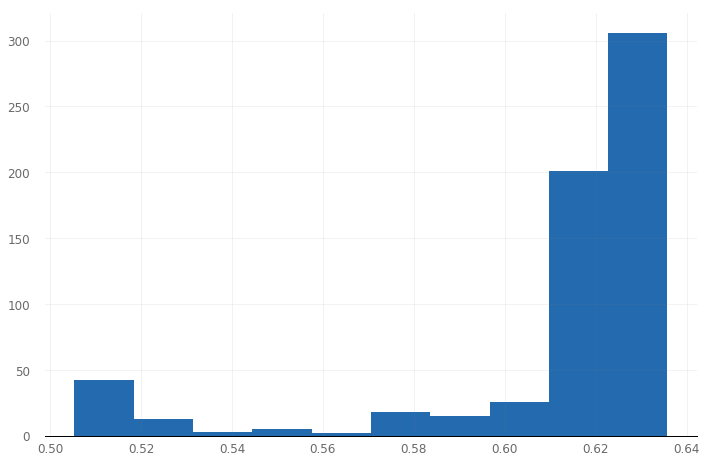

In [8]:
r.plot_hist()

In [9]:
r.high()

0.6357796379209656

In [19]:
data = TFile.Open("/home/minerva1993/public/v808/nosplit/ttHbb_PowhegPythia.root")
data2 = TFile.Open("/home/minerva1993/public/v808/nosplit/TTLJ_PowhegPythia_ttbb.root")
tree = data.Get("ttbbLepJets/tree")
tree2 = data2.Get("ttbbLepJets/tree")

In [20]:
def tree_to_df(tree, branch_names=[], index_name='', drop_roofit_labels=False):
    if tree is None:
        return None

    branch_list = tree.GetListOfBranches()
    all_branch_names = [branch_list.At(i).GetName() for i in range(branch_list.GetEntries())]
    if len(branch_names) == 0:
        branch_names = all_branch_names
    for bn in branch_names[:]:
        if bn not in all_branch_names:
            branch_names.remove(bn)
        if drop_roofit_labels:
            if bn.endswith('_lbl'):
                branch_names.remove(bn)

    arrs = tree2array(tree, branch_names)
    df = pd.DataFrame(arrs)

    if len(index_name) == 0:
        for col in df.columns:
            if col.startswith('__index__'):
                index_name = col
                break
    if len(index_name):
        try:
            df[index_name] = df[index_name].astype(np.int32)
            df.set_index(index_name, inplace=True)
        except BaseException:
            pass

    if drop_roofit_labels:
        df.columns = [col.replace('_idx', '') for col in df.columns]

    n_tree = tree.GetEntries()
    n_df = len(df.index)

    return df 

In [21]:
dftree = tree_to_df(tree)
dftree_bg = tree_to_df(tree2)

In [22]:
def process_delta_phi(x):
    if x > math.pi:
        delta_phi = x - 2*math.pi
    elif x < -math.pi:
        delta_phi = x + 2*math.pi
    else:
        delta_phi = x
    return delta_phi

def calculate_delta_R(phi_1, phi_2, eta_1, eta_2):
    x = phi_1 - phi_2
    delta_phi = process_delta_phi(x)
    delta_eta = eta_1 - eta_2
    return math.sqrt(delta_phi**2 + delta_eta**2)

In [27]:
def generate(df):
    
    columns = ['draddjets','lepton_pT','lepton_eta','lepton_E','MET','MET_phi','jet_number','event_weight','delta_phi','delta_eta','delta_R','invmass','lepton_delta_R_1','lepton_delta_eta_1','lepton_delta_R_2','lepton_delta_eta_2','H']
    
    for t in range(1,3):
        for i in ['jet_pT','jet_eta','jet_E','jet_CvsB']:
            columns.append(i+'_'+str(t))
    
    columns.append('result')
    
    overall = []
    
    for i in range(len(df['lepton_SF'])):
        if df['jet_number'][i] >= 6 and df['jet_CSV'][i][2] > 0.8:
            checked = 0
            for m in range(df['jet_number'][i]):
                if df['jet_pT'][i][m] > 20 and np.abs(df['jet_eta'][i][m]) < 2.4:
                    checked += 1
            if checked < 6:
                continue
                
            count = 0
            
            #append all the invariant columns
            invariants = []
            
            for t in ['draddjets','lepton_pT','lepton_eta','lepton_E','MET','MET_phi','jet_number']:
                invariants.append(df[t][i])
                
            product = df['lepton_SF'][i][0] * df['jet_SF_CSV_30'][i][0] * df['PUWeight'][i][0] * df['genweight'][i]
            invariants.append(product)
            
            #Loop over possible combinations
            for t in range(len(df['jet_pT'][i]) - 1):
                for m in range(t+1, len(df['jet_pT'][i])):
                
                    #initialize variant data column
                    variants = []

                    #set the jet pair
                    jet_pair = (t,m)

                    #Delta_phi, delta_eta and delta_R
                    x = df['jet_phi'][i][jet_pair[0]] - df['jet_phi'][i][jet_pair[1]]
                    delta_phi = process_delta_phi(x)
                    delta_eta = df['jet_eta'][i][jet_pair[0]] - df['jet_eta'][i][jet_pair[1]]
                    delta_R = math.sqrt(delta_phi**2 + delta_eta**2)

                    #invmass
                    pt1, pt2 = math.fabs(df['jet_pT'][i][jet_pair[0]]), math.fabs(df['jet_pT'][i][jet_pair[1]])
                    pX1, pX2 = pt1 * math.cos(df['jet_phi'][i][jet_pair[0]]), pt2 * math.cos(df['jet_phi'][i][jet_pair[1]])
                    pY1, pY2 = pt1 * math.sin(df['jet_phi'][i][jet_pair[0]]), pt2 * math.sin(df['jet_phi'][i][jet_pair[1]])
                    pZ1, pZ2 = pt1 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][i][jet_pair[0]]))), pt2 / math.tan(2.0 * math.atan(math.exp(-df['jet_eta'][i][jet_pair[1]])))
                    invmass = math.sqrt((df['jet_E'][i][jet_pair[0]] + df['jet_E'][i][jet_pair[1]])**2 - (pX1 + pX2)**2 - (pY1 + pY2)**2 - (pZ1 + pZ2)**2)

                    #H
                    H = df['jet_pT'][i][jet_pair[0]] + df['jet_pT'][i][jet_pair[1]] + df['lepton_pT'][i]

                    #delta_lepton_R
                    y_1 = df['jet_phi'][i][jet_pair[0]] - df['lepton_phi'][0]
                    delta_phi_lep_1 = process_delta_phi(y_1)
                    delta_eta_lep_1 = df['jet_eta'][i][jet_pair[0]] - df['lepton_eta'][0]
                    delta_R_lep_1 = math.sqrt(delta_phi_lep_1**2 + delta_eta_lep_1**2)

                    y_2 = df['jet_phi'][i][jet_pair[1]] - df['lepton_phi'][0]
                    delta_phi_lep_2 = process_delta_phi(y_2)
                    delta_eta_lep_2 = df['jet_eta'][i][jet_pair[1]] - df['lepton_eta'][0]
                    delta_R_lep_2 = math.sqrt(delta_phi_lep_2**2 + delta_eta_lep_2**2)

                    variants += [delta_phi, delta_eta, delta_R, invmass, delta_R_lep_1, delta_eta_lep_1, delta_R_lep_2, delta_eta_lep_2, H]

                    for n in [t, m]:
                        for k in ['jet_pT','jet_eta','jet_E','jet_CvsB']:
                            variants += [df[k][i][n]]

                    phi_1, phi_2 = df['jet_phi'][i][jet_pair[0]], df['jet_phi'][i][jet_pair[1]]
                    mt_phi_1, mt_phi_2 = df['addbjet1_phi'][i], df['addbjet2_phi'][i]
                    eta_1, eta_2 = df['jet_eta'][i][jet_pair[0]], df['jet_eta'][i][jet_pair[1]]
                    mt_eta_1, mt_eta_2 = df['addbjet1_eta'][i], df['addbjet2_eta'][i]

                    dR_11 = calculate_delta_R(phi_1, mt_phi_1, eta_1, mt_eta_1)
                    dR_12 = calculate_delta_R(phi_1, mt_phi_2, eta_1, mt_eta_2)
                    dR_21 = calculate_delta_R(phi_2, mt_phi_1, eta_2, mt_eta_1)
                    dR_22 = calculate_delta_R(phi_2, mt_phi_2, eta_2, mt_eta_2)

                    variants.append(1 if (dR_11 < 0.4 or dR_12 < 0.4) and (dR_21 < 0.4 or dR_22 < 0.4) else 0)
                    count += 1
                
                    overall.append(invariants + variants)
            
    print "Column Length: ", len(overall[0])
    print "Fixed Length: ", len(columns)

    train_tree = pd.DataFrame(overall, columns=columns)
    return train_tree

In [28]:
train = generate(dftree_bg)

Column Length:  26
Fixed Length:  26


In [97]:
# train.to_csv('../HYU_data/jet_selection_train.csv', sep = '\t')

In [3]:
train = pd.read_csv('../HYU_data/jet_selection_train.csv', sep='\t',index_col=0)

/home/9304220184/python27/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
train.head()

,draddjets,lepton_pT,lepton_eta,lepton_E,MET,MET_phi,jet_number,event_weight,delta_phi,delta_eta,...,H,jet_pT_1,jet_eta_1,jet_E_1,jet_CvsB_1,jet_pT_2,jet_eta_2,jet_E_2,jet_CvsB_2,result
0,0.565032,75.205696,-0.212312,76.907066,56.96524,2.80331,7,1.005138,1.725019,-2.028580,...,413.128998,77.486115,-1.148836,135.098801,-0.857189,260.437195,0.879744,368.445679,-0.879903,0
1,0.565032,75.205696,-0.212312,76.907066,56.96524,2.80331,7,1.005138,2.397315,-0.446142,...,172.717041,77.486115,-1.148836,135.098801,-0.857189,20.025236,-0.702694,25.641397,-0.881456,0
2,0.565032,75.205696,-0.212312,76.907066,56.96524,2.80331,7,1.005138,2.179603,-2.884358,...,174.154205,77.486115,-1.148836,135.098801,-0.857189,21.462395,1.735522,62.892284,0.100976,0
3,0.565032,75.205696,-0.212312,76.907066,56.96524,2.80331,7,1.005138,-0.687121,-0.079602,...,181.016479,77.486115,-1.148836,135.098801,-0.857189,28.324678,-1.069234,46.525688,0.275004,0
4,0.565032,75.205696,-0.212312,76.907066,56.96524,2.80331,7,1.005138,-1.837705,-0.769005,...,311.631348,77.486115,-1.148836,135.098801,-0.857189,158.939545,-0.379831,172.088455,0.418143,0


In [5]:
def preprocess_data(X, scaler=None):
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

In [6]:
def under_sample(data):
    
    pos_events = data[data['result'] == 1]
    neg_events = data[data['result'] == 0]
    
    #Randomize and pick same n number of events
    number_pos_events = len(pos_events)  

    pos_events = pos_events.reindex(np.random.permutation(pos_events.index))
    neg_events = neg_events.reindex(np.random.permutation(neg_events.index))
        
    undersampled_events = pd.concat([neg_events.head(number_pos_events), pos_events])
    X_data_u, scaler = preprocess_data(undersampled_events.drop('result',1))
    y_data_u = undersampled_events['result'] 

    X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_data_u, y_data_u, test_size=0.3)
    
    return X_train_u, X_test_u, y_train_u, y_test_u, scaler

In [90]:
X_train, X_test, Y_train, Y_test, scaler = under_sample(train)

/home/9304220184/python27/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [92]:
model = Sequential()
model.add(Dropout(0.13, input_shape=(X_train.shape[1],)))
model.add(Dense(75))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(60))
model.add(PReLU())

model.add(Dropout(0.09))
model.add(Dense(45))
model.add(PReLU())

model.add(Dropout(0.07))
model.add(Dense(30))
model.add(PReLU())

model.add(Dropout(0.11))
model.add(Dense(15))
model.add(PReLU())

model.add(Dense(2))
model.add(Activation('sigmoid'))

In [93]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=0.05, nesterov=True), metrics=['accuracy'])

In [94]:
Y_train_nn = np_utils.to_categorical(Y_train)
Y_test_nn = np_utils.to_categorical(Y_test)

In [95]:
model.fit(X_train, Y_train_nn, batch_size=64, epochs=70, verbose=2, shuffle=True, validation_data = (X_test, Y_test_nn))

Train on 53708 samples, validate on 23018 samples
Epoch 1/70
 - 4s - loss: 0.5480 - acc: 0.7214 - val_loss: 0.4702 - val_acc: 0.7790
Epoch 2/70
 - 3s - loss: 0.4920 - acc: 0.7676 - val_loss: 0.4581 - val_acc: 0.7874
Epoch 3/70
 - 3s - loss: 0.4850 - acc: 0.7699 - val_loss: 0.4514 - val_acc: 0.7911
Epoch 4/70
 - 3s - loss: 0.4822 - acc: 0.7710 - val_loss: 0.4534 - val_acc: 0.7886
Epoch 5/70
 - 3s - loss: 0.4766 - acc: 0.7755 - val_loss: 0.4504 - val_acc: 0.7922
Epoch 6/70
 - 3s - loss: 0.4761 - acc: 0.7750 - val_loss: 0.4496 - val_acc: 0.7916
Epoch 7/70
 - 3s - loss: 0.4738 - acc: 0.7770 - val_loss: 0.4515 - val_acc: 0.7925
Epoch 8/70
 - 3s - loss: 0.4751 - acc: 0.7750 - val_loss: 0.4467 - val_acc: 0.7912
Epoch 9/70
 - 3s - loss: 0.4729 - acc: 0.7757 - val_loss: 0.4523 - val_acc: 0.7908
Epoch 10/70
 - 3s - loss: 0.4711 - acc: 0.7775 - val_loss: 0.4473 - val_acc: 0.7942
Epoch 11/70
 - 3s - loss: 0.4682 - acc: 0.7783 - val_loss: 0.4495 - val_acc: 0.7895
Epoch 12/70
 - 3s - loss: 0.4678 - 

In [40]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [96]:
joblib.dump(scaler, 'scaler.save') 
joblib.dump(model, 'jet_selection.h5')
joblib.dump(rf, 'jet_randomforest.h5')

['jet_randomforest.h5']

In [51]:
r = rf.predict(X_test)
Y_valid = np.array(Y_test)
print("Accuracy for Random Forest: %.2f" % (accuracy_score(Y_test, r.round()) * 100))

Accuracy for Random Forest: 81.26


In [42]:
r = rf.predict(X_train)
Y_valid = np.array(Y_train)
print("Accuracy for Random Forest: %.2f" % (accuracy_score(Y_train, r.round()) * 100))

Accuracy for Random Forest: 100.00


In [74]:
nn_test = model.predict(X_test)

In [75]:
result_0 = [nn_test[i] for i in range(len(nn_test)) if Y_test.tolist()[i] == 0] 
result_1 = [nn_test[i] for i in range(len(nn_test)) if Y_test.tolist()[i] == 1]

# sns.kdeplot(result_0, label="Not Higgs")
# sns.kdeplot(result_1, label="Higgs")
# plt.show()

In [82]:
result_0_0 = sum([1 for i in result_0 if i[0] > i[1]])
print(float(result_0_0) / len(result_0))

0.798413805125


In [83]:
result_1_1 = sum([1 for i in result_1 if i[0] < i[1]])
print(float(result_1_1) / len(result_1))

0.817307692308


In [58]:
nn_test = model.predict(X_test)
nn_test = np.array([i[1] for i in nn_test])
print("Accuracy for the Combined Model: %.2f" % (accuracy_score(Y_test, nn_test.round()) * 100))

Accuracy for the Combined Model: 49.85
